# Data Science Case Study

### Submission By: Ismail Khan
#### Date: 02/18/2021

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import openpyxl

#### Reading CDC data into pandas dataframe and re-coding States into their respective names

In [2]:
df = pd.read_csv('CDC_data.txt', sep="\t", engine = 'python', error_bad_lines=False)

df['_STATE'] = df['_STATE'].replace([9.0, 34.0, 36.0], ['CONNECTICUT', 'NEW JERSEY', 'NEW YORK'])

#### Using only columns for State & Physical Health, data cleansing is performed. 

##### Assumptions: 
From Physical health, no. of days between 1 - 30 are considered whereas everything else is dropped in order to only use relevant data. Since we are interested in the number of "bad" days, assumption is made that PHYSHLTH = 88.0 (0 days) is insignificant as zero bad days would skew the mean. 



In [3]:
#Reducing original dataset to only the columns needed for Q1
df_q1 = df.drop(df.columns.difference(['_STATE','PHYSHLTH']), 1)

#Renaming column name for ease of use.
df_q1 = df_q1.rename(columns={'_STATE': 'STATE'})

#Dropping unwanted data points from PHYSHLTH column
df_q1.drop(df_q1.index[(df_q1['PHYSHLTH'] == 77.0) | (df_q1['PHYSHLTH'] == 88.0) | (df_q1['PHYSHLTH'] == 99.0) ], inplace = True)

#Calculating mean & std for each State
mean_std = df_q1.groupby("STATE")["PHYSHLTH"].agg([np.mean, np.median, np.std])

#Breaking df_q1 into three dataframes for each state to calculate ANOVA for finding statistical significance
df_NY = df_q1[(df_q1['STATE'] == 'NEW YORK')]
df_CT = df_q1[(df_q1['STATE'] == 'CONNECTICUT')]
df_NJ = df_q1[(df_q1['STATE'] == 'NEW JERSEY')]

r, p = f_oneway(df_NY['PHYSHLTH'], df_CT['PHYSHLTH'], df_NJ['PHYSHLTH'])

#### Q1. How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state?  Provide an indication of distribution using whatever statistics or charts you find suitable. 

Analysis: Constructing Boxplot to compare Physical Health vs. State. While mean, median & standard deviation is comparable between all three States, New Jersey had the highest in all three values. To better visualize these plots, I exported this dataframe into an excel file that could be used in Tableau. 

New Jersey recorded 933 people that were sick for 30 days, this amount is almost twice as much for Connecticut (472) and New York (451). All three States showed that majority of the people sick were under 10 days, this is usually how long it takes to clinically recover from the common cold. 

For all residents sick, New Jersey had the highest count of 4,251 whereas Connecticut reported 2,592 and New York was 2,532. In addition, Q3 for NJ is higher than CT & NY. With these measures alone, it can be concluded that New Jersey residents experienced the worst physical health amongst three States. 


#### Q2. How do you know if the above difference between states is statistically significant? 

One-way ANOVA: The one-way analysis of variance (ANOVA) is used to determine whether there are any statistically significant differences between the means of three or more independent (unrelated) groups. For one-way ANOVA, the hypotheses for the test are listed below. A significance level of 0.05 indicates a 5% risk of concluding that a difference exists when there is no actual difference.

1. The null hypothesis (H0) is that the group means are all equal.
2. The alternative hypothesis (HA) is that not all group means are equal.

In this case, P-Value = 5.72e-06 which is less than 0.05, therefore these results are **statistically significant** meaning there are significant differences between States.

                  mean  median        std
STATE                                    
CONNECTICUT  10.430941     5.0  10.667561
NEW JERSEY   11.732769     6.0  11.237568
NEW YORK     10.929700     5.0  10.801091 

F-Statistic Value 12.0867
P-Value 5.72e-06


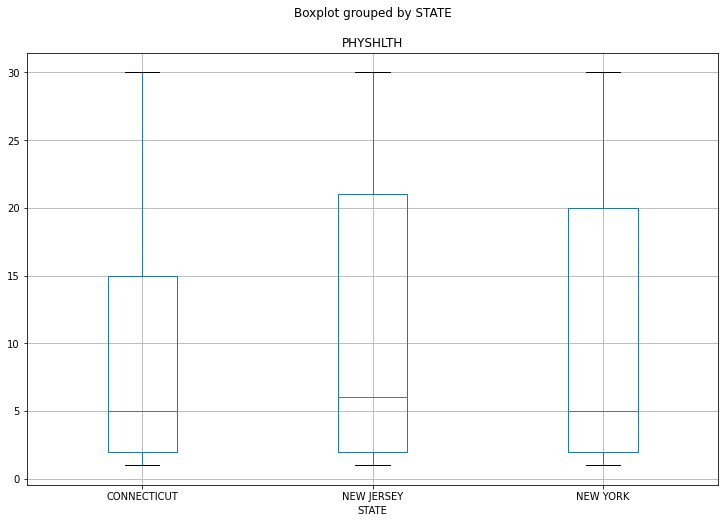

In [4]:
#Creating boxplots to visualize data for each State
df_q1.boxplot('PHYSHLTH', by='STATE', figsize=(12, 8))
print (mean_std, '\n')
print ('F-Statistic Value', round(r,4))
print ('P-Value', round(p,8))

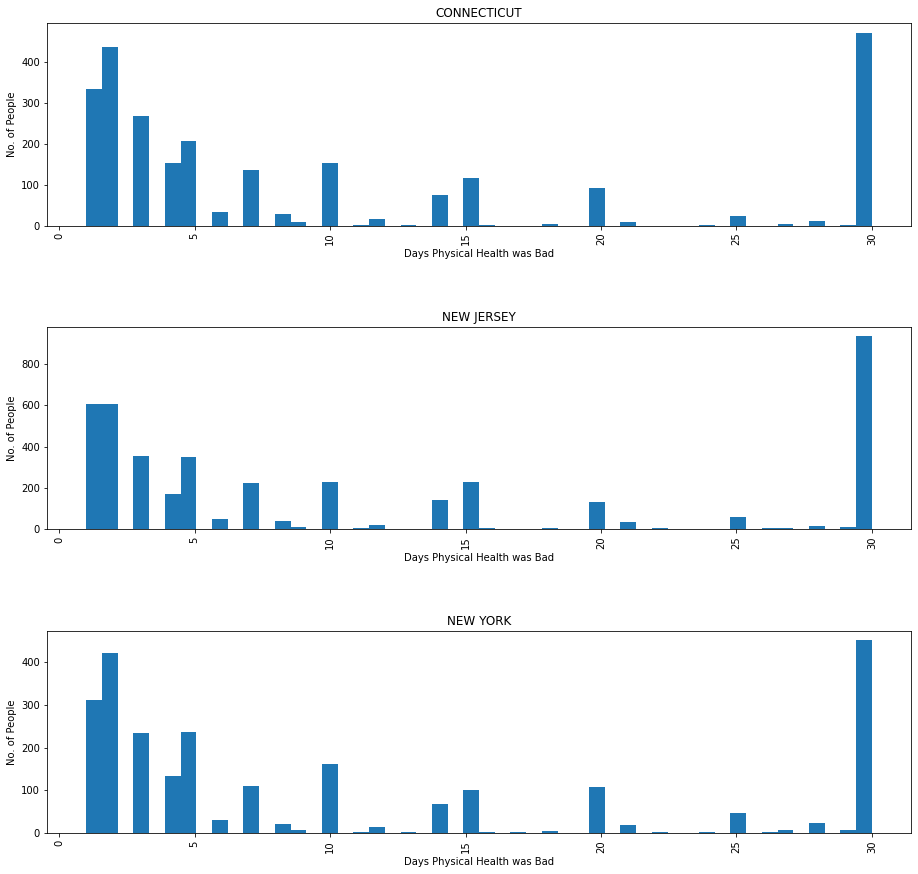

In [5]:
#Creating Histograms to visualize data for each State
hist1 = df_q1.hist(column = 'PHYSHLTH', by = 'STATE' , layout = (3, 1), bins = 50, figsize = (15,15))
for ax in hist1.flatten():
    ax.set_xlabel("Days Physical Health was Bad")
    ax.set_ylabel("No. of People")

#### Q3. Digging deeper into the data, what are the top predictor variables impacting health (i.e. demographics, behaviors, previous illness, etc.)?

Predicting the effects of body weight, BMI, SEX and physical activity on experiencing bad physical health. 

Running correlations amongst these variables, we see weak positive relationships for Weight & BMI, whereas there is a negative relationship for Exercise(Dummy) & Sex(Dummy). There is a moderate and significant correlation between Exercise and Physical Health, which means that individuals who do not exercise regularly also tend to report more sick days.

I ran a multiple regression model to understand the impact of Exercise, Weight, Sex, and BMI (which served as the independent variables) on Physical Health (the dependent variable). For all 4 independent variables, the P-value is less than 0.05 stating that results are statistically significant, meaning that changes in each of the independent variables are related to change in physical health. 

In this case, the R-Squared value is much less than 0.50. However, studies that try to explain human behavior generally have R2 values less than 50%. Because people are harder to predict than things like physical processes. Therefore, we can still draw important conclusions from the analysis, and we can do so by looking at the **statistically significant coefficients** of each independent variable. 

Regression coefficients represent the mean change in the independent variable for one unit of change in physical health (dependent variable). So, these results suggest for each one unit increase in BMI is associated with a slight increase in physical health, whereas a one unit increase in weight is associated with a slight decrease in physical health.

In [6]:
#for Q3 only keeping variables of interest to find correlations between other variables impacting health
#In this case I have chosen to compare Weight, Sex, Exercise (in last 30 days) & BMI of an individual
df_q3 = df.drop(df.columns.difference(['_STATE','PHYSHLTH','WEIGHT2','SEX','EXERANY2', '_BMI5']), 1)

#Renaming columns for ease of use
df_q3 = df_q3.rename(columns={'_STATE': 'STATE', 'WEIGHT2': 'WEIGHT', 'EXERANY2': 'EXERCISE', '_BMI5': 'BMI'})

#Dropping unwanted data points from PHYSHLTH column
df_q3.drop(df_q3.index[(df_q3['PHYSHLTH'] == 77.0) | (df_q3['PHYSHLTH'] == 88.0) | (df_q3['PHYSHLTH'] == 99.0) ], inplace = True)

#Dropping unwanted data points from WEIGHT column
df_q3.drop(df_q3.index[(df_q3['WEIGHT'] > 500.0)], inplace = True)

#Dropping unwanted data points from SEX column
df_q3.drop(df_q3.index[(df_q3['SEX'] > 2.0)], inplace = True)

#Dropping unwanted data points from EXERCISE column
df_q3.drop(df_q3.index[(df_q3['EXERCISE'] > 2.0)], inplace = True)

#Dropping NaN data points from the entire dataframe
df_q3.dropna(inplace = True)

# Dummy coding categorical variables to accurately run regression models
# for SEX_DUMMY Male = 0 & female = 1
# for EXERCISE Yes = 1, No = 0
df_q3['SEX_DUMMY'] = df_q3['SEX'].replace([1,2], [0,1])
df_q3['EXERCISE_DUMMY'] = df_q3['EXERCISE'].replace([1,2], [1,0])

#Running correlations between all variables to check for relationships
df_q3.corr()

,PHYSHLTH,EXERCISE,WEIGHT,SEX,BMI,SEX_DUMMY,EXERCISE_DUMMY
PHYSHLTH,1.000000,0.285597,0.076465,0.012965,0.118236,0.012965,-0.285597
EXERCISE,0.285597,1.000000,0.090831,0.058670,0.143793,0.058670,-1.000000
WEIGHT,0.076465,0.090831,1.000000,-0.374627,0.866612,-0.374627,-0.090831
SEX,0.012965,0.058670,-0.374627,1.000000,-0.051740,1.000000,-0.058670
BMI,0.118236,0.143793,0.866612,-0.051740,1.000000,-0.051740,-0.143793
SEX_DUMMY,0.012965,0.058670,-0.374627,1.000000,-0.051740,1.000000,-0.058670
EXERCISE_DUMMY,-0.285597,-1.000000,-0.090831,-0.058670,-0.143793,-0.058670,1.000000


In [7]:
# Performing multivariable linear regression to understand the effect of variables on PHYSHLTH
reg = LinearRegression()

# Creating two dataframes for dependent & independent variables
X = df_q3[['EXERCISE_DUMMY', 'WEIGHT', 'SEX_DUMMY', 'BMI']]
y = df_q3['PHYSHLTH']

# Fitting the model on variables & calculating Coefficients, Y-intercept
reg.fit(X,y)
Intercept=reg.intercept_
Coefficients=list(reg.coef_)

print('Y-Intercept = ',round(Intercept,4), '\n')
print ('Coefficients = \n', Coefficients)

Y-Intercept =  12.5421 

Coefficients = 
 [-6.4318664330304305, -0.027362182332542444, -0.8468224980724678, 0.002933230698853914]


In [8]:
# Running Ordinary Least Square (OLS) to estimate P-Values for each variables
# to understand if results are statisically significant
# Fitting the OLS model on X,y variables

X=sm.add_constant(X) 
model= sm.OLS(y,X).fit() 
predictions= model.summary()
predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PHYSHLTH   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     212.3
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          5.06e-174
Time:                        13:48:50   Log-Likelihood:                -32549.
No. Observations:                8636   AIC:                         6.511e+04
Df Residuals:                    8631   BIC:                         6.514e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.5421      0.597     20.999      0.000      11.371      13.713
EXERCISE_DUMMY    -6.4319      0.245    -26.210      0.000      -6.913      -5.951
WEIGHT            -0.0274      0.006     -4.276      0.000      -0.040      -0.015
SEX_DUMMY         -0.8468      0.308     -2.754      0.006      -1.450      -0.244
BMI                0.0029      0.000      6.989      0.000       0.002       0.004
==============================================================================
Omnibus:                     1086.069   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.938
Skew:                           0.764   Prob(JB):                    1.35e-219
Kurtosis:                       2.319   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Q4. If you had additional time, what other types of data mining techniques and / or analytical modeling would you explore with this dataset?

1. Finding where the significance lies between other variables
2. Understand how physical health is different amongst other races
3. Investigate physical health data based on disease trends in the region. Such as how seasonal flu is impacting physical    health. 
4. Compare healthcare expenditure per 100k residents versus number of bad physical health days suffered by citizens
5. Compare health amongst all SES (Socio-Economic Status) levels
6. Conduct Post-hoc analyses to run comparative studies: 
    i. Duncan’s Multiple Range Test (MRT)
    ii. Tukey Honest Significance Difference (HSD)
7. Use the regression model to create supervised machine learning algorithm to predict physical health status based on given features.